# Covid-19 Radiology Segmentation & Classification
COMP 478 Project
<br>
Jeremy Gaudet
<br>
ID: 40045224
<br>
April 25, 2021

In [66]:
import tensorflow as tf
from tensorflow import keras
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from keras.preprocessing.image import ImageDataGenerator,array_to_img
import pandas as pd
import numpy as np
from PIL import Image
from packaging import version
import io
import tensorboard
import os
from glob import glob

In [67]:
# import sys
# from google.colab import drive
# drive.mount('/content/gdrive')
# sys.path.append('/content/gdrive/My Drive/COMP478 Project/')
# %cd /content/gdrive/My Drive/COMP478 Project/

### Global variables

In [68]:
PATH = '/Users/jeremygaudet/Downloads/COVID-19_Radiography_Dataset'
BATCH_SIZE = 32
IMAGE_SIZE = (64, 64)
IMAGE_WIDTH = IMAGE_SIZE[0]
IMAGE_HEIGHT = IMAGE_SIZE[1]

### Load the images

In [69]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=0.1,
    subset="training",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=1337,
    label_mode="int",
    color_mode="grayscale"
)

Found 21165 files belonging to 4 classes.
Using 19049 files for training.


In [70]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=0.1,
    subset="validation",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=1337,
    label_mode="int",
    color_mode="grayscale"
)

Found 21165 files belonging to 4 classes.
Using 2116 files for validation.


# Data Analysis

In this dataset, the chest x-ray images are divided into four classes:

In [71]:
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)
print(CLASS_NAMES)

['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']


In [74]:
import scipy.ndimage as ndimage


def reshape_image(image):
    # image = tf.image.random_brightness(image, max_delta=.5)
    # image = tf.image.random_contrast(image, .3, 1.7)
    # image = tf.image.random_flip_left_right(image)
    # noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=4, dtype=tf.float32)
    # image = tf.add(image, noise)
    bimage = ndimage.gaussian_filter(image, sigma=1)

    # tf.enable_eager_execution()
    # img = tf.random.normal(shape=tf.shape(image),dtype=tf.float32) # replace with your image data
    # grad_components = tf.image.sobel_edges(img)
    # grad_mag_components = grad_components**2
    # grad_mag_square = tf.math.reduce_sum(grad_mag_components,axis=-1) # sum all magnitude components
    # grad_mag_img = tf.sqrt(grad_mag_square) 


    # sobel = tf.image.sobel_edges(image)
    # image = tf.reshape(image, [-1, IMAGE_HEIGHT, IMAGE_WIDTH, 1])  # 6 channel

    y = image
    image = tf.where(bimage > 200., 0, y)

    return image

def tf_reshape_image(image, label):
    im_shape = image.shape
    [image,] = tf.py_function(reshape_image, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label

train_ds_reshaped = train_ds.map(tf_reshape_image)
train_ds = train_ds.concatenate(train_ds_reshaped)
train_ds.shuffle(buffer_size=len(train_ds)*BATCH_SIZE)

<ShuffleDataset shapes: ((None, 64, 64, 1), (None,)), types: (tf.float32, tf.int32)>

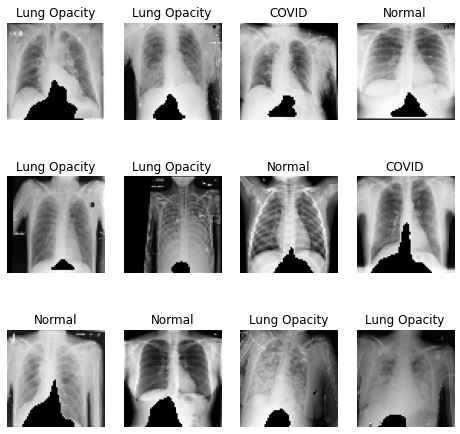

In [75]:
def show(image, label):
    plt.imshow(image, cmap='gray')
    plt.title(CLASS_NAMES[label])
    plt.axis('off')

plt.figure(figsize=(8, 8))
for image, label in train_ds_reshaped.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        show(image[i], label[i])

The number of images in each class, however, is not evenly distrubuted, as can be seen in the following tables and graph. The biggest difference is between 'Viral Pneumonia' and 'Normal', where the latter has almost eight times as many instances as the former.

In [9]:
# # # Get all training and validation labels and put them into separate lists
# # # NOTE This can take a while
# training_labels = np.concatenate([y for x, y in train_ds], axis=0)
# validation_labels = np.concatenate([y for x, y in val_ds], axis=0)

In [10]:
# # Use pandas to store the image count of each class in the training set
# unique, counts = np.unique(training_labels, return_counts=True)
# train_df = pd.DataFrame(dict(zip(CLASS_NAMES, counts)).items(), columns=["class", "image count"])
# # Do the same for validation set
# unique, counts = np.unique(validation_labels, return_counts=True)
# val_df = pd.DataFrame(dict(zip(CLASS_NAMES, counts)).items(), columns=["class", "image count"])

# print('Distribution of training data:\n')
# print(train_df)
# print('\n\nDistribution of validation data:\n')
# print(val_df)

In [11]:
# def display_distribution_donut(data_frame):
#     fig, ax = plt.subplots(figsize=(3, 3), subplot_kw=dict(aspect="equal"))

#     categories = data_frame['class']
#     img_count = data_frame['image count']

#     wedges, texts = ax.pie(
#         img_count, 
#         wedgeprops=dict(width=0.5), 
#         startangle=-40, 
#         colors=['lightcoral','lightsalmon', 'cornflowerblue', 'mediumaquamarine'])

#     bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
#     kw = dict(arrowprops=dict(arrowstyle="-"),
#             bbox=bbox_props, zorder=0, va="center")

#     for i, p in enumerate(wedges):
#         ang = (p.theta2 - p.theta1)/2. + p.theta1
#         y = np.sin(np.deg2rad(ang))
#         x = np.cos(np.deg2rad(ang))
#         horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
#         connectionstyle = "angle,angleA=0,angleB={}".format(ang)
#         kw["arrowprops"].update({"connectionstyle": connectionstyle})
#         ax.annotate(f'{categories[i]}\n{img_count[i]}', xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
#                     horizontalalignment=horizontalalignment, **kw)
#     plt.title("Distribution of\ntraining images", loc='left')
#     plt.show()

# display_distribution_donut(train_df)

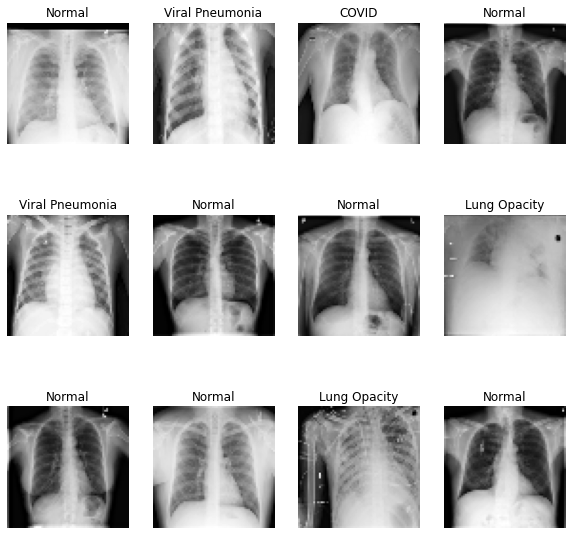

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 64, 64, 1)
(32,)


# Image Processing

In [14]:
from keras import layers

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMAGE_HEIGHT, 
                                                              IMAGE_WIDTH,
                                                              1)),
    # layers.experimental.preprocessing.RandomRotation(0.01),
    # layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

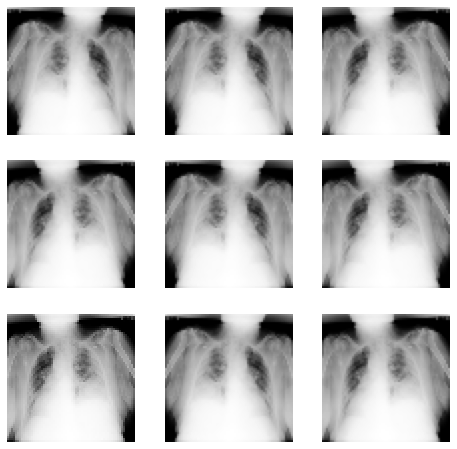

In [15]:
plt.figure(figsize=(8, 8))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"), cmap="gray")
        plt.axis("off")

# Classification

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
model = tf.keras.Sequential([ 
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(NUM_CLASSES)
])

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 1)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)      

In [19]:
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
1192/1192 [==============================] - 53s 44ms/step - loss: 0.7985 - accuracy: 0.6695 - val_loss: 0.5488 - val_accuracy: 0.7817
Epoch 2/10
1192/1192 [==============================] - 35s 29ms/step - loss: 0.4968 - accuracy: 0.8075 - val_loss: 0.4732 - val_accuracy: 0.8223
Epoch 3/10
1192/1192 [==============================] - 35s 29ms/step - loss: 0.4267 - accuracy: 0.8382 - val_loss: 0.4411 - val_accuracy: 0.8388
Epoch 4/10
1192/1192 [==============================] - 35s 30ms/step - loss: 0.3834 - accuracy: 0.8535 - val_loss: 0.4133 - val_accuracy: 0.8492
Epoch 5/10
1192/1192 [==============================] - 35s 29ms/step - loss: 0.3482 - accuracy: 0.8679 - val_loss: 0.4332 - val_accuracy: 0.8431
Epoch 6/10
1192/1192 [==============================] - 35s 29ms/step - loss: 0.3216 - accuracy: 0.8787 - val_loss: 0.3910 - val_accuracy: 0.8625
Epoch 7/10
1192/1192 [==============================] - 35s 30ms/step - loss: 0.2950 - accuracy: 0.8885 - val_loss: 0.4060 -

KeyboardInterrupt: 

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

In [ ]:
def validation_data_categories(test_images):
    y_pred = model.predict(test_images)
    predicted_cat = tf.argmax(y_pred, axis=1)
    true_cat = tf.concat([y for x, y in test_images], axis=0)
    return true_cat, predicted_cat

def plot_confusion_matrix(true_cat, predicted_cat):
    cm = confusion_matrix(predicted_cat, true_cat)
    display = ConfusionMatrixDisplay(cm, display_labels=CLASS_NAMES).plot()
    plt.show()

# Show the confusion matrix and the report
true_cat, pred_cat = validation_data_categories(val_ds)
plot_confusion_matrix(true_cat, pred_cat)
print('\n', classification_report(true_cat, pred_cat, target_names=CLASS_NAMES))

In [ ]:
# test_image_path = "/Users/jeremygaudet/Downloads/istockphoto-173883249-612x612.jpg"
# test_image_path = "/Users/jeremygaudet/Downloads/c3-1-e1586266398823.jpg.webp"
# test_image_path = "/Users/jeremygaudet/Downloads/normal-lung-xray-15x10-by-Yale-Rosen.jpg"
test_image_path = "/Users/jeremygaudet/Desktop/Screen Shot 2021-04-23 at 9.28.57 AM.png"

img = keras.preprocessing.image.load_img(test_image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT, 1), color_mode='grayscale')

# Plot image
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray')
plt.axis("off")

# Load a model
# model_256 = keras.models.load_model('models/covid_lung_model_256_preprocess_drop_big.h5')

# Preprocess image
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
# Make predictions on images
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
# Get index for highest confidence class
idx = np.argmax(score)

print(f'This image is {CLASS_NAMES[idx]} with {score[idx]*100:0.2f}% confidence')

In [ ]:
# Save the entire model to a HDF5 file.
# !mkdir models/
# model.save('models/covid_lung_model_256_preprocess_drop_big.h5')